## Problem:

- In out problem, need to detect the nearest pedestrian road to see if the car is violating or not 
- need to know which part is the pedestrian road and which part is the car road  

In [1]:
import os
import sys
import cv2
import time
import mmcv
import torch
import numpy as np
import ffmpeg
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

repo_path = Path(".").absolute().parent

if os.system == "nt":
    data_path = Path("D:\Datas\parking_violation")
else:
    data_path = repo_path.parent / "data" / "parking_violation"
# pkg_path = repo_path.parent / "PINet_new"
sys.path.append(str(repo_path))
# sys.path.append(str(pkg_path))

In [2]:
import mmseg
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette

from utils import imsaver, correct_rgb, resize_image
config_path = repo_path.parent / "mmsegmentation" / "configs" / "resnest"
checkpoint_path = repo_path.parent / "data" / "mmseg" / "checkpoints"
if not checkpoint_path.exists():
    checkpoint_path.mkdir(parents=True)

```
!wget https://download.openmmlab.com/mmsegmentation/v0.5/resnest/deeplabv3plus_s101-d8_512x1024_80k_cityscapes/deeplabv3plus_s101-d8_512x1024_80k_cityscapes_20200807_144429-1239eb43.pth -P ~/code/data/mmseg/checkpoints/
```

In [3]:
# !wget "https://download.openmmlab.com/mmsegmentation/v0.5/resnest/deeplabv3plus_s101-d8_512x1024_80k_cityscapes/deeplabv3plus_s101-d8_512x1024_80k_cityscapes_20200807_144429-1239eb43.pth" -P ~/code/data/mmseg/checkpoints/

In [4]:
config_file = str(config_path / "deeplabv3plus_s101-d8_512x1024_80k_cityscapes.py")
checkpoint_file = str(checkpoint_path / "deeplabv3plus_s101-d8_512x1024_80k_cityscapes_20200807_144429-1239eb43.pth")

In [5]:
model = init_segmentor(config_file, checkpoint_file, device='cuda:0')

In [6]:
video_path = str(data_path / "sample1.mp4")
video = mmcv.VideoReader(video_path)
img = video[100]

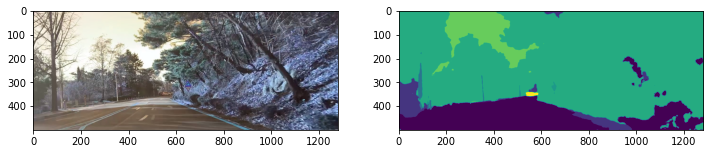

In [9]:
crop_img = img[:500]
result = inference_segmentor(model, crop_img)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(crop_img)
axes[1].imshow(result[0])
plt.show()

In [148]:
# Preprocess video
height, width = 360, 640
video_path = str(data_path / "sample1.mp4")
resized_video_path = str(data_path / f"sample1_{height}x{width}.mp4")
resized_frames_path = data_path / f"sample1_{height}x{width}"
if not resized_frames_path.exists():
    resized_frames_path.mkdir()
video_output_path = str(data_path / f"sample1_{height}x{width}-result.mp4")

In [ ]:
mmcv.resize_video(video_path, resized_video_path, (width, height))

In [153]:
from mmseg.datasets import CityscapesDataset, CustomDataset, build_dataloader
# from mmseg.apis.inference import LoadImage
# from mmseg.datasets.pipelines import Compose

In [174]:
def frame_loader(video, step=30, preprocess=None):
    idx = np.arange(len(video), step=step)
    for i in idx:
        img = video[i]
        if preprocess:
            img = preprocess(img)
        yield img
        

In [179]:
video = mmcv.VideoReader(resized_video_path)
preprocessor = lambda x: x[:270]
data_loader = frame_loader(video, step=30, preprocess=preprocessor)
for i, frame in tqdm(enumerate(data_loader, 1), total=(len(video)//30 + 1), desc="Processing"):
    result = inference_segmentor(model, frame)
    overlay_img = model.show_result(frame, result, palette=CityscapesDataset.PALETTE, show=False)
    imsaver(overlay_img, str(resized_frames_path / f"sample1-{i}.jpg"))

Processing: 100%|██████████| 121/121 [01:26<00:00,  1.39it/s]


In [182]:
from moviepy.editor import concatenate_videoclips, ImageClip
imgs = list(map(str, resized_frames_path.glob("*.jpg")))

clips = [ImageClip(m).set_duration(1) for m in imgs]

concat_clip = concatenate_videoclips(clips, method="compose")
concat_clip.write_videofile(str(data_path / f"sample1_{height}x{width}-result.mp4"), fps=30)

t:   2%|▏         | 59/3630 [00:00<00:06, 578.20it/s, now=None]

Moviepy - Building video /home/simonjisu/code/data/parking_violation/sample1_360x640-result.mp4.
Moviepy - Writing video /home/simonjisu/code/data/parking_violation/sample1_360x640-result.mp4



Moviepy - Done !
Moviepy - video ready /home/simonjisu/code/data/parking_violation/sample1_360x640-result.mp4


In [202]:
import ipywidgets as wd
from IPython.display import display, HTML

In [203]:
def show_video(path):
    display(HTML("""
        <video width=640 height=270 controls>
          <source src="{}" type="video/mp4">
        </video>
        """.format(path))
   )

In [206]:
wd.interact(show_video, path = video_path);

interactive(children=(Text(value='/home/simonjisu/code/data/parking_violation/sample1_360x640/sample1_360x640.…